# FENE beadspring with variable kuhn length experiment data analysis

In [144]:
import os

import polyflexmd.data_analysis.data.read as read
import polyflexmd.data_analysis.transform.transform as transform
import polyflexmd.data_analysis.theory.kremer_grest as kremer_grest
import polyflexmd.data_analysis.plot.plot_system as plot_system
import polyflexmd.experiment_runner.config as config
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import numpy as np
from pandarallel import pandarallel
import seaborn as sns


In [145]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [146]:
sns.set_style("darkgrid")

In [147]:
pandarallel.initialize(
    nb_workers=len(os.sched_getaffinity(0)),
    progress_bar=False,
    use_memory_fs=False
)

INFO: Pandarallel will run on 128 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


## Read and process data

In [148]:
PATH_EXPERIMENT = "/scratch/ws/0/s4610340-bt-eea1-md-workspace/.dev/test-results/FENE-beadspring-vary-l_K/test-4-FENE-beadspring-vary-l_K-taurus-mpi/2f60f914"
NAME_EC = "test-4-FENE-beadspring-vary-l_K-taurus-mpi.toml"

In [149]:
PATH_EXPERIMENT = pathlib.Path(PATH_EXPERIMENT)
PATH_SYSTEM_DEF = PATH_EXPERIMENT / "data/initial_system.data"
PATH_EC = PATH_EXPERIMENT / NAME_EC

### Read experiment config

In [150]:
conf = config.read_experiment_config(PATH_EC)
conf

ExperimentConfig(simulation_config=SimulationConfig(job=SlurmJobConfig(account='p_mdpolymer', time='1:00:00', partition='romeo', nodes=2, tasks_per_node=128, ntasks=256, cpus_per_task=1, mem_per_cpu=1000), simulation_model_path=PosixPath('simulations/FENE-beadspring-vary-l_K.lammps'), experiments_path=PosixPath('/scratch/ws/0/s4610340-bt-eea1-md-workspace/.dev/test-results'), n_partitions=2, n_tasks_per_partition=128, variables={'kappa_start': 1.0, 'kappa_delta': 5, 'kappa_n_values': 8, 'n_relax_steps': 100000, 'n_equilibrium_steps': 100000}), system_creator_config=SystemCreatorConfig(job=SlurmJobConfig(account='p_mdpolymer', time='1:00:00', partition='romeo', nodes=1, tasks_per_node=1, ntasks=1, cpus_per_task=4, mem_per_cpu=1000), venv_path=PosixPath('/scratch/ws/0/s4610340-bt-eea1-md-workspace/polyflexmd/.venv'), system_config=AnchoredFENEChainConfig(name='anchored-fene-chain', n_chains=40, n_monomers=128, monomer_type=2, bond_type=1, angle_type=1, bond_length=0.97, box_length=200, s

In [151]:
kappas: list[float] = [
    conf.simulation_config.variables["kappa_start"] + conf.simulation_config.variables["kappa_delta"] * i
    for i in range(conf.simulation_config.variables["kappa_n_values"])
]
kappas

[1.0, 6.0, 11.0, 16.0, 21.0, 26.0, 31.0, 36.0]

### Read initial system

In [152]:
system = read.read_lammps_system_data(PATH_SYSTEM_DEF)
system.atoms

,molecule-ID,type,x,y,z,ix,iy,iz
1,1,1,0.000000,0.000000,0.000000,0,0,0
2,1,1,0.764233,-0.425729,-0.419050,0,0,0
3,1,2,0.773821,-0.836732,0.459520,0,0,0
4,1,2,1.285179,-0.524169,-0.303184,0,0,0
5,1,2,0.842282,0.329744,-0.427985,0,0,0
...,...,...,...,...,...,...,...,...
5116,40,2,-8.806796,0.070591,-4.480917,0,0,0
5117,40,2,-8.040260,-0.270179,-3.993886,0,0,0
5118,40,2,-7.295676,-0.582204,-4.531599,0,0,0
5119,40,2,-7.689637,0.070740,-3.932133,0,0,0


In [153]:
system.bonds

,type,atom1,atom2
1,1,1,2
2,1,2,3
3,1,3,4
4,1,4,5
5,1,5,6
...,...,...,...
5076,1,5115,5116
5077,1,5116,5117
5078,1,5117,5118
5079,1,5118,5119


In [154]:
system.angles

,type,atom1,atom2,atom3
1,1,1,2,3
2,1,2,3,4
3,1,3,4,5
4,1,4,5,6
5,1,5,6,7
...,...,...,...,...
5036,1,5114,5115,5116
5037,1,5115,5116,5117
5038,1,5116,5117,5118
5039,1,5117,5118,5119


In [155]:
system.box

-100.000000 100.000000  xlo xhi
-100.000000 100.000000  ylo yhi
-100.000000 100.000000  zlo zhi

### Read and process trajectories

In [156]:
PATH_DATA_PROCESSED = PATH_EXPERIMENT / "data" / "processed"
PATH_DATA_PROCESSED.mkdir(exist_ok=True)
PATH_DF_TRAJECTORY_PROCESSED = PATH_DATA_PROCESSED / "trajectory_unfolded_kappas.csv"
PATH_DF_TRAJECTORY_PROCESSED

PosixPath('/scratch/ws/0/s4610340-bt-eea1-md-workspace/.dev/test-results/FENE-beadspring-vary-l_K/test-4-FENE-beadspring-vary-l_K-taurus-mpi/2f60f914/data/processed/trajectory_unfolded_kappas.csv')

In [157]:
def read_and_process_kappas_df(experiment_path: pathlib.Path, kappas: list[float]):
    dfs = []
    for i in range(1, len(kappas) + 1):
        paths_trajectories = [
            experiment_path / "data" / f"polymer_relax-{i}.out",
            experiment_path / "data" / f"polymer-{i}.out"
        ]
        print(f"Reading {paths_trajectories}...")
        if not all(p.exists() for p in paths_trajectories):
            break

        df_trajectory_unfolded = transform.unfold_coordinates_df(
            trajectory_df=transform.join_raw_trajectory_df_with_system_data(
                raw_trajectory_df=read.read_multiple_raw_trajectory_dfs(paths_trajectories),
                system_data=system
            ),
            system_data=system
        )
        df_trajectory_unfolded["kappa"] = kappas[i-1]
        dfs.append(df_trajectory_unfolded)

    return pd.concat(dfs)


if PATH_DF_TRAJECTORY_PROCESSED.exists():
    print("Reading processed...")
    df_trajectory_unfolded_kappas = pd.read_csv(PATH_DF_TRAJECTORY_PROCESSED)
else:
    print("Reading and processing...")
    df_trajectory_unfolded_kappas = read_and_process_kappas_df(PATH_EXPERIMENT, kappas)
    print("Writing...")
    df_trajectory_unfolded_kappas.to_csv(PATH_DF_TRAJECTORY_PROCESSED, index=False)

df_trajectory_unfolded_kappas

Reading processed...


,t,id,type,x,y,z,ix,iy,iz,molecule-ID,kappa
0,0,1,1,0.000000,0.000000,0.000000,0,0,0,1,1.0
1,0,2,1,0.764233,-0.425729,-0.419050,0,0,0,1,1.0
2,0,3,2,0.773821,-0.836732,0.459520,0,0,0,1,1.0
3,0,4,2,1.285180,-0.524169,-0.303184,0,0,0,1,1.0
4,0,5,2,0.842282,0.329744,-0.427985,0,0,0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...
532475,200000,5116,2,-7.079810,-6.069930,-7.823730,0,0,0,40,36.0
532476,200000,5117,2,-6.468220,-6.510230,-8.458460,0,0,0,40,36.0
532477,200000,5118,2,-5.701140,-6.634950,-9.063780,0,0,0,40,36.0
532478,200000,5119,2,-4.870430,-6.566390,-9.666630,0,0,0,40,36.0


In [158]:
df_trajectory_unfolded_kappas.groupby(["kappa"])["t"].describe()

,count,mean,std,min,25%,50%,75%,max
kappa,,,,,,,,
1.0,66560.0,134615.384615,50324.769531,0.0,110000.0,140000.0,170000.0,200000.0
6.0,66560.0,134615.384615,50324.769531,0.0,110000.0,140000.0,170000.0,200000.0
11.0,66560.0,134615.384615,50324.769531,0.0,110000.0,140000.0,170000.0,200000.0
16.0,66560.0,134615.384615,50324.769531,0.0,110000.0,140000.0,170000.0,200000.0
21.0,66560.0,134615.384615,50324.769531,0.0,110000.0,140000.0,170000.0,200000.0
26.0,66560.0,134615.384615,50324.769531,0.0,110000.0,140000.0,170000.0,200000.0
31.0,66560.0,134615.384615,50324.769531,0.0,110000.0,140000.0,170000.0,200000.0
36.0,66560.0,134615.384615,50324.769531,0.0,110000.0,140000.0,170000.0,200000.0


## Calculate and plot observables relax+equi

In [159]:
l_b_src = .97
L_src = l_b_src*(conf.system_creator_config.system_config.n_monomers-1)
L_src

123.19

### End-to-End distance $\vec{R}$

In [160]:
PATH_ETE = PATH_EXPERIMENT / "data" / "processed" / "ete.csv"

if PATH_ETE.exists():
    print("Reading processed...")
    df_ete = pd.read_csv(PATH_ETE, index_col=["kappa", "t", "molecule-ID"])
else:
    print("Processing...")
    df_ete = df_trajectory_unfolded_kappas.groupby("kappa").apply(transform.calc_end_to_end_df)
    print("Writing...")
    df_ete.to_csv(PATH_ETE, index=True)

df_ete

Reading processed...


R_x      R_y        R_z          R
kappa t      molecule-ID                                        
1.0   0      1            9.84474 -2.70184   7.548270  12.696268
      100000 1            4.56569 -2.31217   4.628760   6.900513
      110000 1            9.74419 -1.24403  10.471900  14.358187
      120000 1            9.11057 -5.24307   4.288360  11.352634
      130000 1            6.80367 -4.31261   0.468936   8.068980
...                           ...      ...        ...        ...
36.0  160000 40          -4.85116 -3.11928  -9.965840  11.514410
      170000 40          -5.07853 -2.15532  -8.554680  10.179363
      180000 40          -5.70958  1.01187  -9.288380  10.949757
      190000 40          -3.98740 -3.54176 -10.034500  11.363741
      200000 40          -4.13000 -6.55654 -10.233100  12.835944

[3840 rows x 4 columns]

In [161]:
df_ete["t/LJ"] = df_ete.index.get_level_values("t").map(lambda x: x * 0.0025)
df_ete["R^2"] = df_ete["R"] ** 2
df_ete

R_x      R_y        R_z          R   t/LJ  \
kappa t      molecule-ID                                                  
1.0   0      1            9.84474 -2.70184   7.548270  12.696268    0.0   
      100000 1            4.56569 -2.31217   4.628760   6.900513  250.0   
      110000 1            9.74419 -1.24403  10.471900  14.358187  275.0   
      120000 1            9.11057 -5.24307   4.288360  11.352634  300.0   
      130000 1            6.80367 -4.31261   0.468936   8.068980  325.0   
...                           ...      ...        ...        ...    ...   
36.0  160000 40          -4.85116 -3.11928  -9.965840  11.514410  400.0   
      170000 40          -5.07853 -2.15532  -8.554680  10.179363  425.0   
      180000 40          -5.70958  1.01187  -9.288380  10.949757  450.0   
      190000 40          -3.98740 -3.54176 -10.034500  11.363741  475.0   
      200000 40          -4.13000 -6.55654 -10.233100  12.835944  500.0   

                                 R^2  
kappa t      molecule-ID              
1.0   0      1            161.195225  
      100000 1             47.617074  
      110000 1            206.157539  
      120000 1            128.882300  
      130000 1             65.108431  
...                              ...  
36.0  160000 40           132.581628  
      170000 40           103.619421  
      180000 40           119.897188  
      190000 40           129.134613  
      200000 40           164.761452  

[3840 rows x 6 columns]

In [162]:
df_ete_mean = df_ete.groupby(["kappa", "t"])[["R^2"]].mean()
df_ete_mean["l_K"] = kremer_grest.bare_kuhn_length(
    np.array(df_ete_mean.index.get_level_values("kappa")),
    l_b=l_b_src
)
df_ete_mean

R^2        l_K
kappa t                            
1.0   0       126.013356   1.854017
      100000  157.981801   1.854017
      110000  159.028767   1.854017
      120000  158.164844   1.854017
      130000  170.523217   1.854017
...                  ...        ...
36.0  160000  421.651540  68.870000
      170000  402.719904  68.870000
      180000  427.413385  68.870000
      190000  442.711988  68.870000
      200000  466.562054  68.870000

[96 rows x 2 columns]

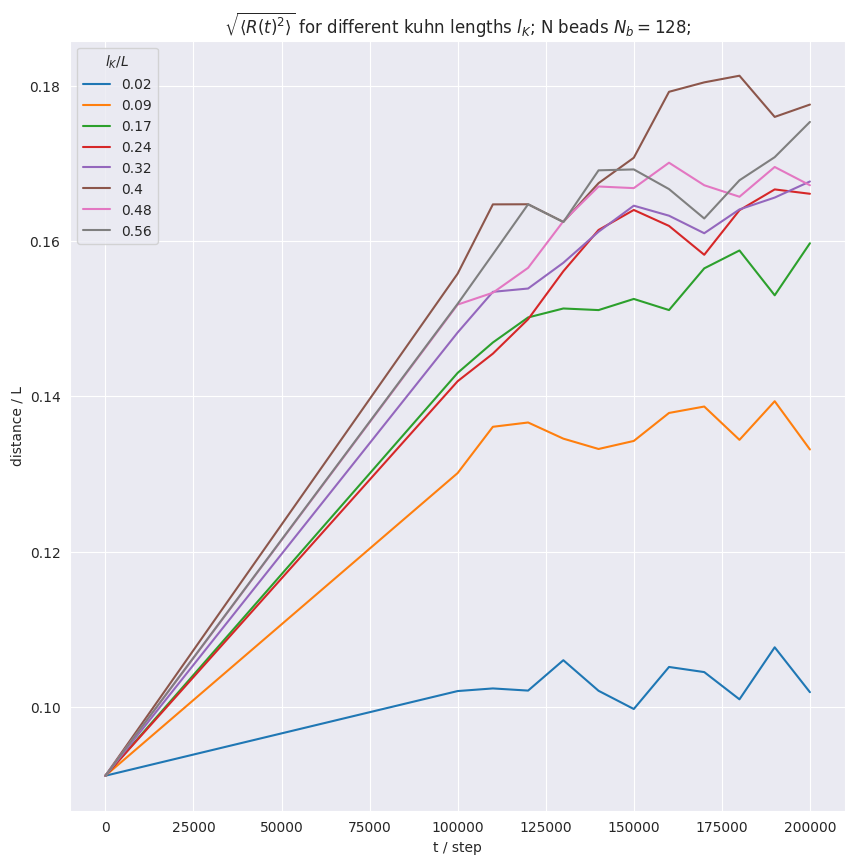

In [163]:
kappa_colors = sns.color_palette(n_colors=len(kappas))

ax: plt.Axes
fig: plt.Figure
fig, ax = plt.subplots(figsize=(10,10))
ax.set(
    title=f'$\sqrt{{\\langle R(t)^2 \\rangle }}$ for different kuhn lengths $l_K$; '
          f'N beads $N_b={conf.system_creator_config.system_config.n_monomers}$;',
    ylabel="distance / L",
    xlabel="t / step"
)

sns.lineplot(
    x=df_ete_mean.index.get_level_values("t"),
    y=np.sqrt(df_ete_mean["R^2"]) / L_src,
    hue=(df_ete_mean["l_K"]/L_src).round(2).astype("category"),
    color=kappa_colors,
    ax=ax
)

ax.get_legend().set_title("$l_K/L$")

## Equilibrium statistics

In [164]:
t_equilibrium = conf.simulation_config.variables["n_relax_steps"]
t_equilibrium

100000

In [165]:
df_trajectory_unfolded_kappas_equi = df_trajectory_unfolded_kappas.loc[df_trajectory_unfolded_kappas["t"] > t_equilibrium]
df_trajectory_unfolded_kappas_equi

,t,id,type,x,y,z,ix,iy,iz,molecule-ID,kappa
15360,110000,1,1,0.000000,0.000000,0.000000,0,0,0,1,1.0
15361,110000,2,1,0.764233,-0.425729,-0.419050,0,0,0,1,1.0
15362,110000,3,2,0.651557,-0.902293,-1.240810,0,0,0,1,1.0
15363,110000,4,2,-0.090690,-1.488510,-1.138070,0,0,0,1,1.0
15364,110000,5,2,0.815570,-1.607630,-0.969154,0,0,0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...
532475,200000,5116,2,-7.079810,-6.069930,-7.823730,0,0,0,40,36.0
532476,200000,5117,2,-6.468220,-6.510230,-8.458460,0,0,0,40,36.0
532477,200000,5118,2,-5.701140,-6.634950,-9.063780,0,0,0,40,36.0
532478,200000,5119,2,-4.870430,-6.566390,-9.666630,0,0,0,40,36.0


In [177]:
df_ete_kappas_equi = df_ete.iloc[df_ete.index.get_level_values("t") >= t_equilibrium]
df_ete_kappas_equi

R_x      R_y        R_z          R   t/LJ  \
kappa t      molecule-ID                                                  
1.0   100000 1            4.56569 -2.31217   4.628760   6.900513  250.0   
      110000 1            9.74419 -1.24403  10.471900  14.358187  275.0   
      120000 1            9.11057 -5.24307   4.288360  11.352634  300.0   
      130000 1            6.80367 -4.31261   0.468936   8.068980  325.0   
      140000 1            7.90513 -1.35404   2.315040   8.347689  350.0   
...                           ...      ...        ...        ...    ...   
36.0  160000 40          -4.85116 -3.11928  -9.965840  11.514410  400.0   
      170000 40          -5.07853 -2.15532  -8.554680  10.179363  425.0   
      180000 40          -5.70958  1.01187  -9.288380  10.949757  450.0   
      190000 40          -3.98740 -3.54176 -10.034500  11.363741  475.0   
      200000 40          -4.13000 -6.55654 -10.233100  12.835944  500.0   

                                 R^2  
kappa t      molecule-ID              
1.0   100000 1             47.617074  
      110000 1            206.157539  
      120000 1            128.882300  
      130000 1             65.108431  
      140000 1             69.683915  
...                              ...  
36.0  160000 40           132.581628  
      170000 40           103.619421  
      180000 40           119.897188  
      190000 40           129.134613  
      200000 40           164.761452  

[3520 rows x 6 columns]

In [178]:
df_ete_mean_equi = df_ete_mean.iloc[df_ete_mean.index.get_level_values("t") > t_equilibrium]
df_ete_mean_equi

R^2        l_K
kappa t                            
1.0   110000  159.028767   1.854017
      120000  158.164844   1.854017
      130000  170.523217   1.854017
      140000  158.085758   1.854017
      150000  150.902634   1.854017
...                  ...        ...
36.0  160000  421.651540  68.870000
      170000  402.719904  68.870000
      180000  427.413385  68.870000
      190000  442.711988  68.870000
      200000  466.562054  68.870000

[80 rows x 2 columns]

### Mean bond length

In [179]:
l_b_df = transform.extract_bond_lengths_df_kappas(df_trajectory_unfolded_kappas_equi, t_equilibrium=conf.simulation_config.variables["n_relax_steps"])
l_b_df

,,l_b
kappa,i,
1.0,0,0.970000
6.0,0,0.970000
11.0,0,0.970000
16.0,0,0.970000
21.0,0,0.970000
...,...,...
16.0,50799,0.942217
21.0,50799,0.973103
26.0,50799,0.949119


In [180]:
l_b_df.groupby("kappa").describe()

l_b                                                              \
         count      mean       std       min       25%       50%       75%   
kappa                                                                        
1.0    50800.0  0.970010  0.033247  0.853773  0.946768  0.967940  0.990876   
6.0    50800.0  0.969907  0.033273  0.860851  0.946531  0.968016  0.990695   
11.0   50800.0  0.969939  0.033230  0.860334  0.946644  0.967831  0.990809   
16.0   50800.0  0.970290  0.033377  0.865017  0.946863  0.968249  0.991068   
21.0   50800.0  0.970197  0.033225  0.866872  0.946905  0.968148  0.990887   
26.0   50800.0  0.970097  0.033297  0.857579  0.946732  0.967962  0.990941   
31.0   50800.0  0.969822  0.033153  0.861326  0.946476  0.967955  0.990578   
36.0   50800.0  0.970025  0.033366  0.870234  0.946594  0.967699  0.990971   

                 
            max  
kappa            
1.0    1.148912  
6.0    1.165365  
11.0   1.140420  
16.0   1.139659  
21.0   1.148167  
26.0   1.141935  
31.0   1.144791  
36.0   1.159497

In [181]:
l_b = conf.system_creator_config.system_config.bond_length
l_b

0.97

### Mean contour length

In [182]:
L_contour = l_b*(conf.system_creator_config.system_config.n_monomers-1)
L_contour

123.19

### Kuhn lengths

In [183]:
l_ks = kremer_grest.bare_kuhn_length(np.array(kappas), l_b)
l_ks

array([ 1.85401695, 10.67085829, 20.37000013, 30.07      , 39.77      ,
       49.47      , 59.17      , 68.87      ])

In [184]:
l_ks / L_contour

array([0.01505006, 0.08662114, 0.16535433, 0.24409449, 0.32283465,
       0.4015748 , 0.48031496, 0.55905512])

### Number of Kuhn segments $N_K$

Estimate $\langle R \rangle$ as average over ensemble and then over time in equilibrium

In [185]:
#transform.calculate_ete_sq_t_avg(df_ete_mean, t_equilibrium=conf.simulation_config.variables["n_relax_steps"])
t_equilibrium=conf.simulation_config.variables["n_relax_steps"]
df_ete_sq_t_mean_kappas = transform.calculate_ete_sq_t_avg_df_kappas(df_ete_mean_equi, t_equilibrium)
df_ete_sq_t_mean_kappas

,R^2
kappa,
1.0,161.821896
6.0,279.985294
11.0,355.986058
16.0,386.171203
21.0,394.608543
26.0,452.076780
31.0,411.549550
36.0,422.218389


Estimate $N_K$ as $\langle R^2 \rangle / L$ (Svaneborg 5,6)

In [186]:
N_Ks = df_ete_sq_t_mean_kappas / L_contour
N_Ks

,R^2
kappa,
1.0,1.313596
6.0,2.272792
11.0,2.889732
16.0,3.134761
21.0,3.203251
26.0,3.669752
31.0,3.340771
36.0,3.427376


### ETE change $ \langle (\Delta R(t))^2 \rangle $

In [ ]:
df_ete_change_kappas_equi = transform.calculate_ens_avg_df_ete_change_kappas(df_ete_kappas_equi)
df_ete_change_kappas_equi["l_K"] = kremer_grest.bare_kuhn_length(df_ete_change_kappas_equi["kappa"], l_b=l_b)
df_ete_change_kappas_equi

In [ ]:
ax: plt.Axes
fig: plt.Figure
fig, ax = plt.subplots(figsize=(10,10))
ax.set(
    title=f'$ \sqrt {{\langle (\Delta R(t))^2 \\rangle}} $ for different kuhn lengths $l_K$; '
          f'N beads $N_b={conf.system_creator_config.system_config.n_monomers}$',
    ylabel="distance / L",
    xlabel="t / step"
)

sns.lineplot(
    x=df_ete_change_kappas_equi.index.get_level_values("t"),
    y=np.sqrt(df_ete_change_kappas_equi["dR^2"]) / L_contour,
    hue=(df_ete_change_kappas_equi["l_K"]/L_contour).round(2).astype("category"),
    color=kappa_colors,
    ax=ax
)

ax.get_legend().set_title("$l_K/L$")